In [157]:
#关numbawarning
from numba.core.errors import NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaWarning)

from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import numba as nb
import pandas as pd
import cv2
from multiprocessing import Process
from multiprocessing.pool import Pool
import os
import time
from functools import partial
import trimesh
import copy
import math
import open3d as o3d
from trimesh import creation, transformations

In [158]:
forlder_name = 'to_rgb'
sub_forder = 'to_rgb'
file_name = 'to_rgb'
filter_flag = False
rotate_flag = False

In [159]:
if os.path.exists(f'data/{forlder_name}'):
    pass
else:
    os.makedirs(f'data/{forlder_name}')

In [160]:
ply_path = 'to_rgb.ply'

In [161]:
if filter_flag : 
    target_pcd = o3d.io.read_point_cloud(ply_path)
    print(target_pcd)
    #target_pcd,_ = target_pcd.remove_statistical_outlier(nb_neighbors=10,std_ratio=2.0)
    radius = 1
    target_pcd,_ = target_pcd.remove_radius_outlier(nb_points=10, radius=radius)
    target, color = target_pcd.points, target_pcd.colors
    _ = trimesh.PointCloud(target,color).export(f'data/shots/{forlder_name}/{file_name}_filtered.ply')
    print("done")
    pc_original = trimesh.load(f'data/shots/{forlder_name}/{file_name}_filtered.ply')
else:
    pc_original = trimesh.load(ply_path)
    pc_new = copy.deepcopy(pc_original)

    folderName = forlder_name
    subfolderName = sub_forder


In [162]:
if rotate_flag:
    angle = math.pi
    direction = [0, 1, 0]
    center = [0, 0, 0]

    rot_matrix = transformations.rotation_matrix(angle, direction, center)

    pc_new = pc_new.apply_transform(rot_matrix)

In [163]:
pc_new.vertices[:,2] = np.max(pc_new.vertices[:,2]) - pc_new.vertices[:,2] 

In [164]:
pc_new.vertices[:,0] = pc_new.vertices[:,0] - np.min(pc_new.vertices[:,0])
pc_new.vertices[:,1] = pc_new.vertices[:,1] - np.min(pc_new.vertices[:,1])

In [165]:
points = pd.DataFrame(columns=['x','y','z'],data=pc_new.vertices)

In [166]:
indexes = points[((points['x']<800)) & (points['y']<700)].index
pc_final = copy.deepcopy(pc_new)
pc_final.vertices= pc_new.vertices[indexes]
pc_final.colors= pc_new.colors[indexes]

In [167]:
pd.DataFrame(pc_final.vertices).describe()

0             1             2
count  2.216250e+06  2.216250e+06  2.216250e+06
mean   2.188933e+02  1.308809e+02  3.427092e+01
std    1.167618e+02  7.608278e+01  4.185252e+00
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.182557e+02  6.477534e+01  3.104358e+01
50%    2.178934e+02  1.272621e+02  3.370721e+01
75%    3.183201e+02  1.949760e+02  3.736945e+01
max    4.337645e+02  2.768310e+02  1.153090e+02

In [168]:
x_max = np.max(pc_final.vertices[:,0])
x_min= np.min(pc_final.vertices[:,0])
y_max = np.max(pc_final.vertices[:,1])
y_min= np.min(pc_final.vertices[:,1])
boundary = (x_max,x_min,y_max,y_min)

In [169]:
x_max,y_max

(TrackedArray(433.76445007), TrackedArray(276.83104706))

In [170]:
len(pc_new.vertices)

2216250

In [171]:
#image_size = (543*6,181*6)
#image_size = (512,512)
#image_size = (512*16,int(512*16/(y_max/x_max)))
image_size = (512*2, int(512*2*(y_max/x_max))) if y_max/x_max <1 else (512*2, int(512*2*(x_max/y_max))) 
# image_size = (1920,1200)
x_length = np.max(pc_final.vertices[:,0])
y_length = np.max(pc_final.vertices[:,1])
x_distance_per_pixel = x_length/image_size[0]
y_distance_per_pixel = y_length/image_size[1]
distance_per_pixel = (x_distance_per_pixel,y_distance_per_pixel)
distance_per_pixel

(TrackedArray(0.4235981), TrackedArray(0.42393728))

In [172]:
image_size

(1024, 653)

In [173]:
@nb.njit()
def get_height_color_map(vertices, colors,image_size,boundary):
    x_max,x_min,y_max,y_min = boundary
    height_map = np.zeros((image_size),dtype=np.float32)
    color_map = np.zeros((image_size[0],image_size[1],4),dtype=np.float32)
    for i in range(len(vertices)):
        point = vertices[i]
        x = point[0]
        y = point[1]
        z = point[2]
        x = min(int((x-x_min)/(x_max - x_min) * image_size[0] ),image_size[0]-1)
        y = min(int((y-y_min)/(y_max - y_min) * image_size[1]), image_size[1]-1)
        color_map[x,y] = colors[i]
        if z > height_map[x,y]: 
            height_map[x,y] = z
    return height_map, color_map

In [174]:
@nb.njit()
def average_smoth(height_map, color_map,image_size):
    miss_count = 0
    observe_length = 20
    for i in range(observe_length,image_size[0]-observe_length):
        for j in range(observe_length,image_size[1]-observe_length):
            if height_map[i,j]==0:
       
                miss_count += 1
                height_map[i,j] = np.mean(height_map[i-observe_length:i+observe_length,j-observe_length:j+observe_length])
                #color_map[i,j] = np.mean(color_map[i-observe_length:i+observe_length,j-observe_length:j+observe_length].reshape(observe_length*2*observe_length*2,4),axis=0)
    return height_map, color_map, miss_count/(image_size[0]*image_size[1])

In [175]:
height_map, color_map = get_height_color_map(pc_final.vertices, pc_final.colors,image_size,boundary)

In [176]:
miss_points = np.where(height_map==0)

In [177]:
image_size = (image_size[1],image_size[0])

In [178]:
image_size

(653, 1024)

In [179]:
color_map = np.swapaxes(color_map,0,1)/255

In [180]:
color_map.shape

(653, 1024, 4)

In [181]:
#height_map, color_map, miss_percentage = average_smoth(height_map, color_map,image_size)
#miss_percentage

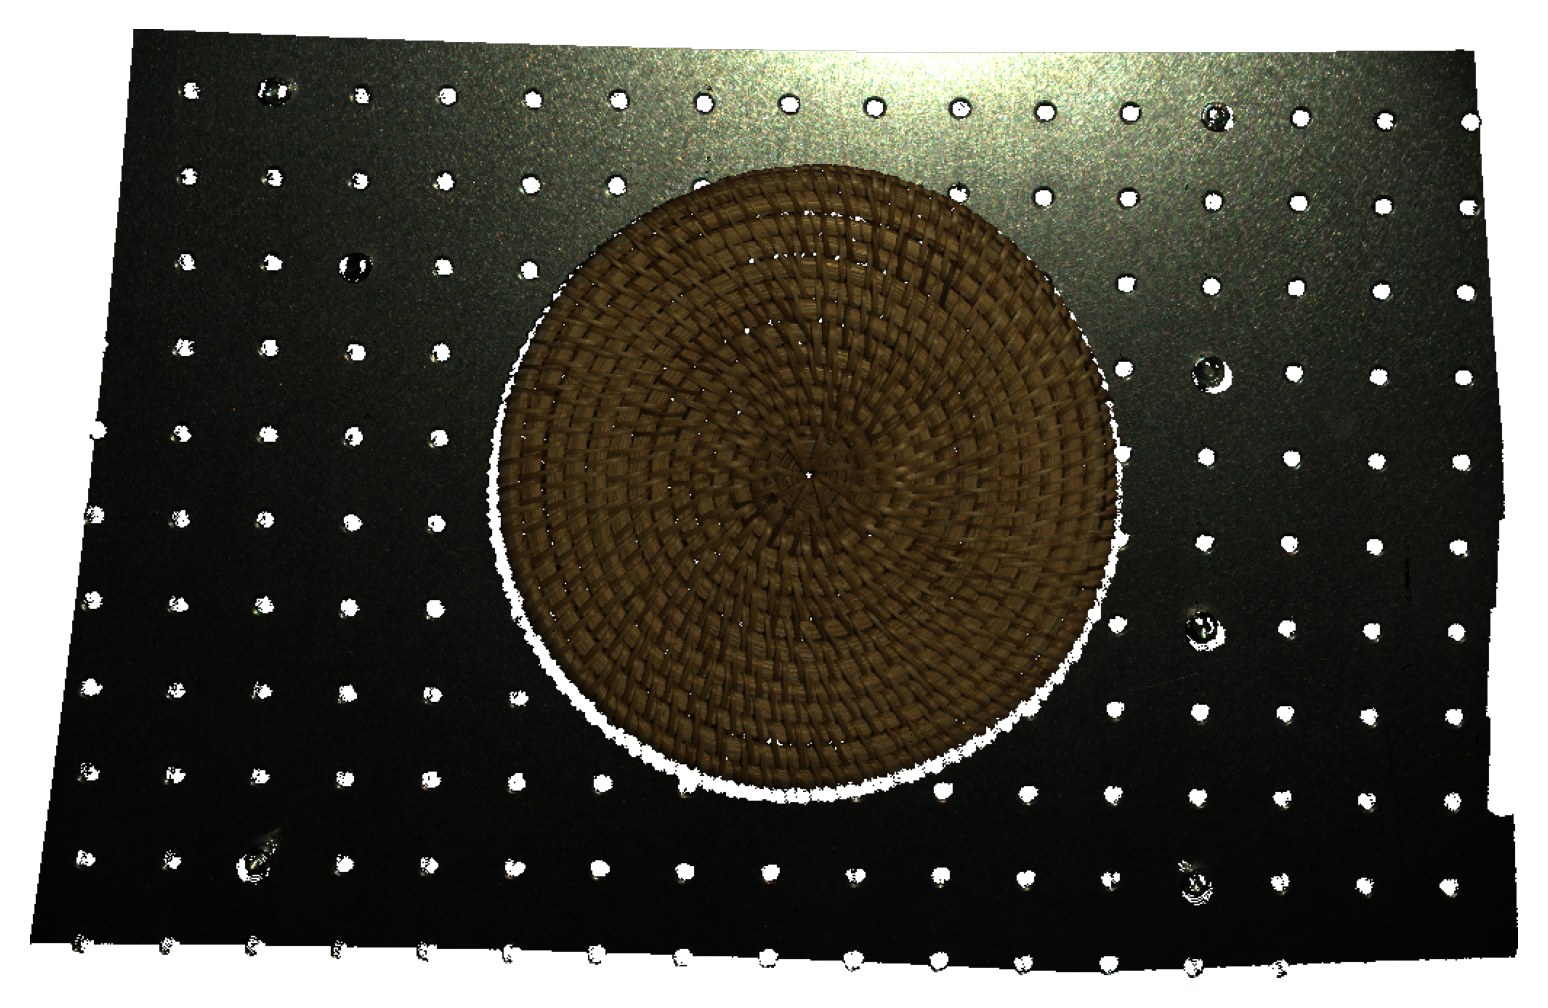

In [182]:
plt.figure(dpi=300)
plt.axis('off')
plt.imshow(color_map)

In [183]:
file_name = f'data/{forlder_name}/{folderName}_{subfolderName}_'+str(image_size[0])+'_'+str(image_size[1])+'_albedo.png'
plt.imsave(file_name,np.ascontiguousarray(color_map))

In [184]:
height_map = np.swapaxes(height_map,0,1)

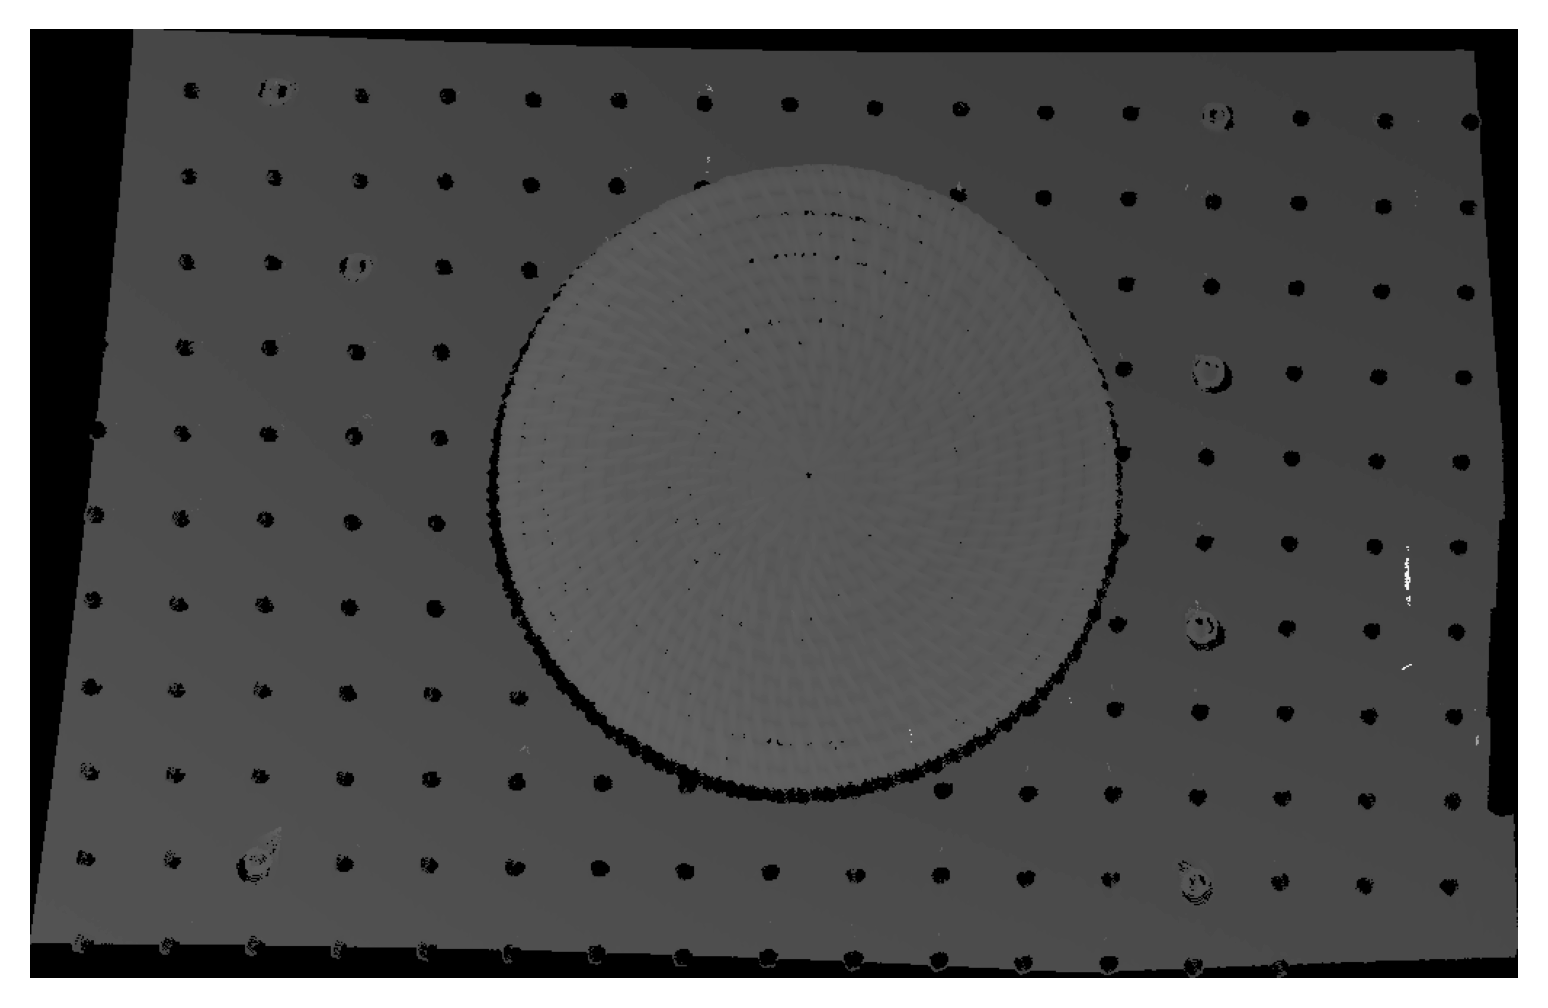

In [185]:
plt.figure(dpi=300)
plt.axis('off')
#plt.imshow(np.swapaxes(height_map,0,1),cmap='gray')
plt.imshow(height_map,cmap='gray')

In [186]:
file_name = f'data/{forlder_name}/{folderName}_{subfolderName}_'+str(image_size[0])+'_'+str(image_size[1])+'_height.png'
print(file_name)
plt.imsave(file_name,height_map.T,cmap='gray')

data/to_rgb/to_rgb_to_rgb_653_1024_height.png


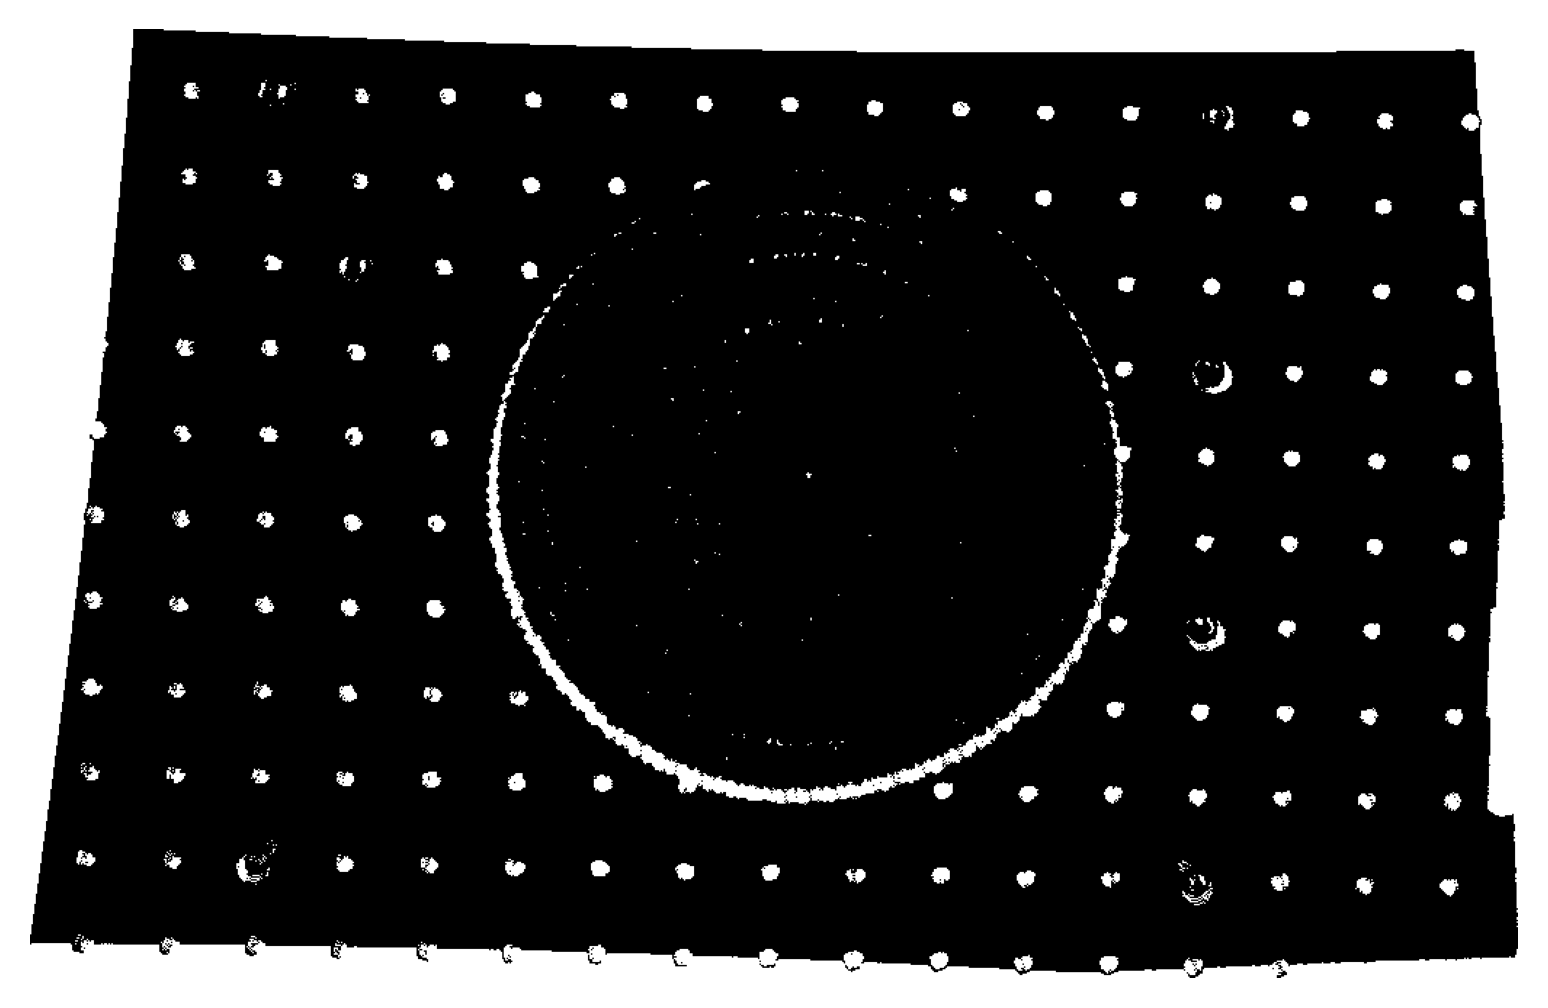

In [187]:
miss_points = np.where(height_map==0)
mask_map = np.zeros((image_size),dtype=np.float32)
for i  in range(len(miss_points[0])):
    mask_map[miss_points[0][i],miss_points[1][i]] = 1
plt.imsave(f'data/{forlder_name}/{forlder_name}_'+str(image_size[0])+'_'+str(image_size[1])+'_missing_mask.png',np.ascontiguousarray(mask_map),cmap='gray')
plt.figure(dpi=300)
plt.axis('off')
plt.imshow(mask_map,cmap='gray')

In [188]:
@nb.jit()
#右手系
def getNormal_dev(heightMap,i,j,distance_per_pixel,strength):
    #X R
    dx = (heightMap[i-1][j+1] - heightMap[i-1][j-1]) + 2*(heightMap[i][j+1] - heightMap[i][j-1]) + (heightMap[i+1][j+1] - heightMap[i+1][j-1])
    dx = min(1,dx*strength/2/4/distance_per_pixel[0])
    #dx = max(dx, 0.000000000000000001)
    #dx = heightMap[i][j+1] - heightMap[i][j-1]
    #Y G 
    g_x = np.array([1,0,dx])
    #dy = (heightMap[i+1][j-1] - heightMap[i-1][j-1]) + 2*(heightMap[i+1][j] - heightMap[i-1][j]) + (heightMap[i+1][j+1] - heightMap[i-1][j+1]) # 左手系
    dy = (heightMap[i-1][j-1] - heightMap[i+1][j-1]) + 2*(heightMap[i-1][j] - heightMap[i+1][j]) + (heightMap[i-1][j+1] - heightMap[i+1][j+1]) # 右手系
    dy = min(1,dy*strength/2/4/distance_per_pixel[1])
    #dy =  max(dy, 0.00000000000000001)
    #dy = heightMap[i+1][j] - heightMap[i-1][j]
    g_y = np.array([0,1,dy])
    n = np.cross(g_x,g_y)
    #n = n/((sum(n**2)**(n)))
    #n = n / (sum(n**2)**(1/2))
    #print(dx,g_x,dy,g_y,n)
    #print(i,j)

    return np.clip(n * 0.5 + 0.5,0,1)

In [189]:
coreNum = os.cpu_count()
nums_list = range(coreNum)

In [190]:
def get_batch_normal(batchID,image_size, heightMap,distance_per_pixel,strength):
    batch_size = int(np.ceil(len(range(1,image_size[0]-1))/ coreNum))
    startID = min(batchID * batch_size,image_size[0])
    endID = min(startID+batch_size,image_size[0])
    if startID == image_size[0]:
        return []
    normalMap = np.ones((endID-startID,image_size[1],3))
    #print(batchID,startID,endID)
    
    for i in range(startID,endID):
        for j in range(1,image_size[1]-1):
            normalMap[i-startID,j,:3] = getNormal_dev(heightMap,i,j,distance_per_pixel,strength=strength) 
    return normalMap

In [191]:
#image_size=height_map.shape
partial_func = partial(get_batch_normal, image_size=image_size, heightMap=height_map,distance_per_pixel=distance_per_pixel,strength=1)
with Pool(coreNum) as p:
      result = list(tqdm(p.imap(partial_func, nums_list), total=len(nums_list)))

100%|██████████| 48/48 [00:01<00:00, 27.09it/s]


In [192]:
normalMap_circle = np.ones((image_size[0],image_size[1],3),dtype=np.float32)
normalMap_circle[0,:,:3] = np.array([0.5,0.5,1])
normalMap_circle[-1,:,:3] = np.array([0.5,0.5,1])
normalMap_circle[:,0,:3] = np.array([0.5,0.5,1])
normalMap_circle[:,-1,:3] = np.array([0.5,0.5,1])

In [193]:
for batchID in range(coreNum):
    batch_size = int(np.ceil(len(range(1,image_size[0]-1))/ coreNum))
    startID = min(batchID * batch_size,image_size[0])
    endID = min(startID+batch_size,image_size[0])
    if startID == image_size[0]:
       break
    #print(startID,endID)
    normalMap_circle[startID:endID,:,:3] = result[batchID]

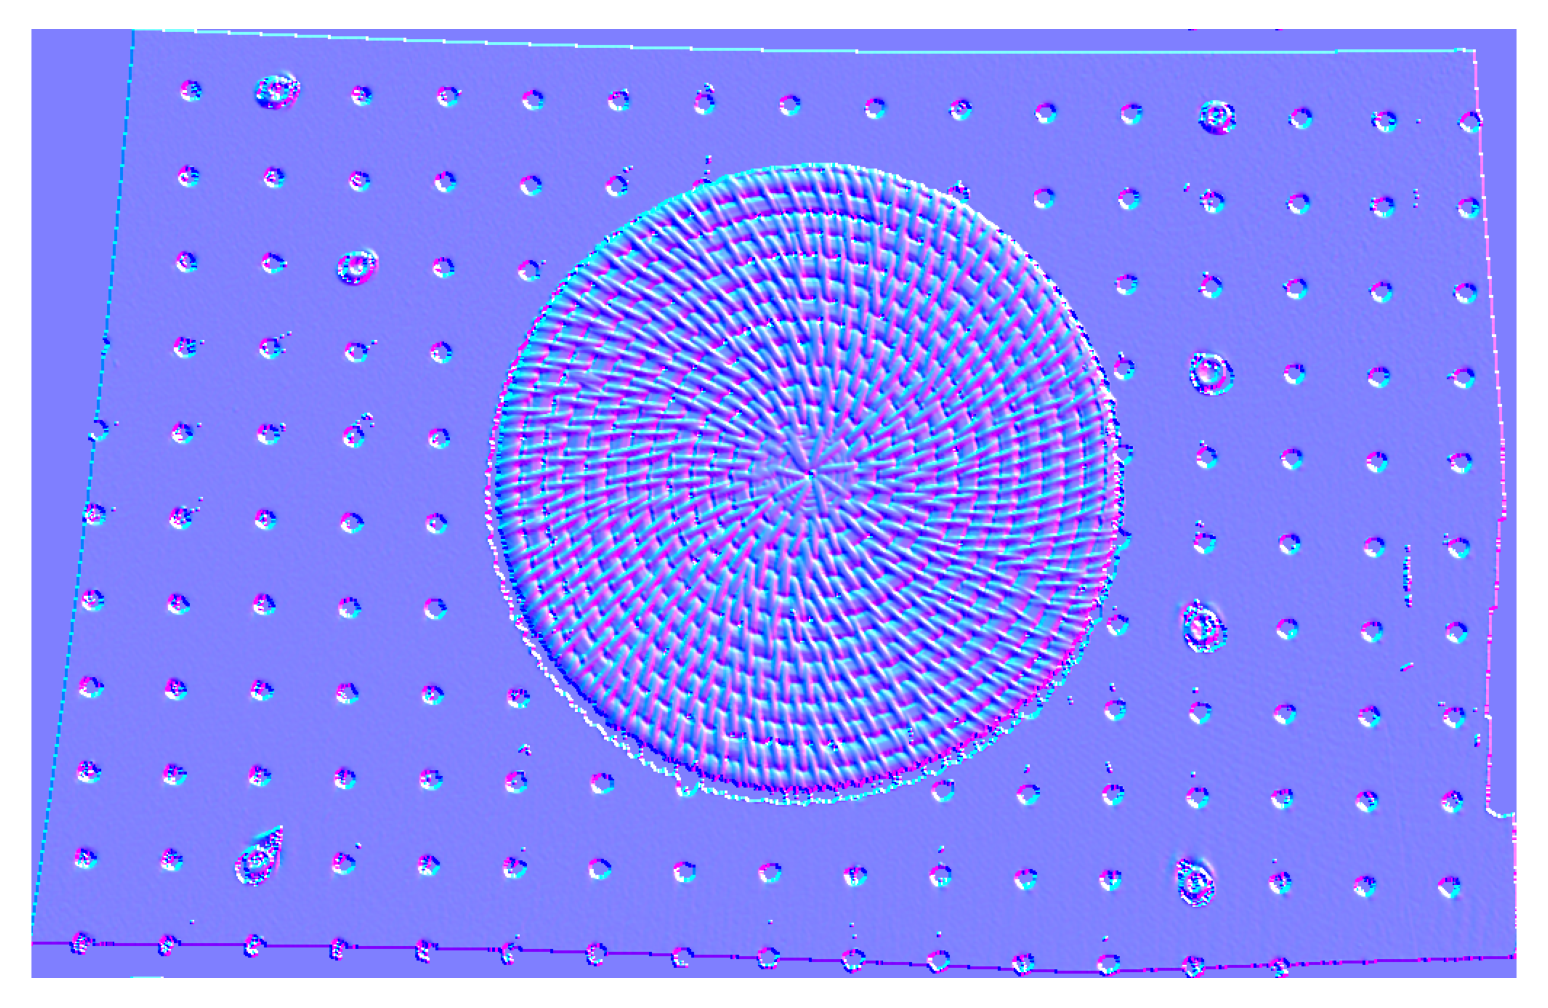

In [194]:
plt.figure(dpi=300)
plt.axis('off')
#plt.imshow(np.swapaxes(normalMap_circle,0,1))
plt.imshow(normalMap_circle)

In [195]:
plt.imsave(f'data/{forlder_name}/{forlder_name}_'+str(image_size[0])+'_'+str(image_size[1])+'_normal.png',normalMap_circle)

In [196]:
@nb.jit()
#右手系
def getNormal_dev_2(heightMap,i,j,distance_per_pixel,strength):
    #X R
    dx = (heightMap[i-1][j+1] - heightMap[i-1][j-1]) + 2*(heightMap[i][j+1] - heightMap[i][j-1]) + (heightMap[i+1][j+1] - heightMap[i+1][j-1])
    #dx = min(1,dx*strength/2/4/distance_per_pixel[0])
    dx = dx/2/4/distance_per_pixel[0]
    if np.abs(dx)<0.1:
        dx = 0
    dx *= strength
    #print(dx)
    #dx = max(dx, 0.000000000000000001)
    #dx = heightMap[i][j+1] - heightMap[i][j-1]
    #Y G 
    g_x = np.array([1,0,dx])
    #dy = (heightMap[i+1][j-1] - heightMap[i-1][j-1]) + 2*(heightMap[i+1][j] - heightMap[i-1][j]) + (heightMap[i+1][j+1] - heightMap[i-1][j+1]) # 左手系
    dy = (heightMap[i-1][j-1] - heightMap[i+1][j-1]) + 2*(heightMap[i-1][j] - heightMap[i+1][j]) + (heightMap[i-1][j+1] - heightMap[i+1][j+1]) # 右手系
    #dy = min(1,dy*strength/2/4/distance_per_pixel[1])
    dy = dy/2/4/distance_per_pixel[1]
    #print(dy)
    if np.abs(dy)<0.1:
        dy = 0
    dy *= strength
    #dy =  max(dy, 0.00000000000000001)
    #dy = heightMap[i+1][j] - heightMap[i-1][j]
    g_y = np.array([0,1,dy])
    n = np.cross(g_x,g_y)
    #n = n/((sum(n**2)**(n)))
    #n = n / (sum(n**2)**(1/2))
    #print(dx,g_x,dy,g_y,n)
    #print(i,j)

    return np.clip(n * 0.5 + 0.5,0,1)

In [197]:
def get_batch_normal_dev(batchID,image_size, heightMap,distance_per_pixel,strength):
    batch_size = int(np.ceil(len(range(1,image_size[0]-1))/ coreNum))
    startID = min(batchID * batch_size,image_size[0])
    endID = min(startID+batch_size,image_size[0])
    if startID == image_size[0]:
        return []
    normalMap = np.ones((endID-startID,image_size[1],3))
    #print(batchID,startID,endID)
    
    for i in range(startID,endID):
        for j in range(1,image_size[1]-1):
            normalMap[i-startID,j,:3] = getNormal_dev_2(heightMap,i,j,distance_per_pixel,strength=strength) 
    return normalMap

100%|██████████| 48/48 [00:01<00:00, 31.12it/s]


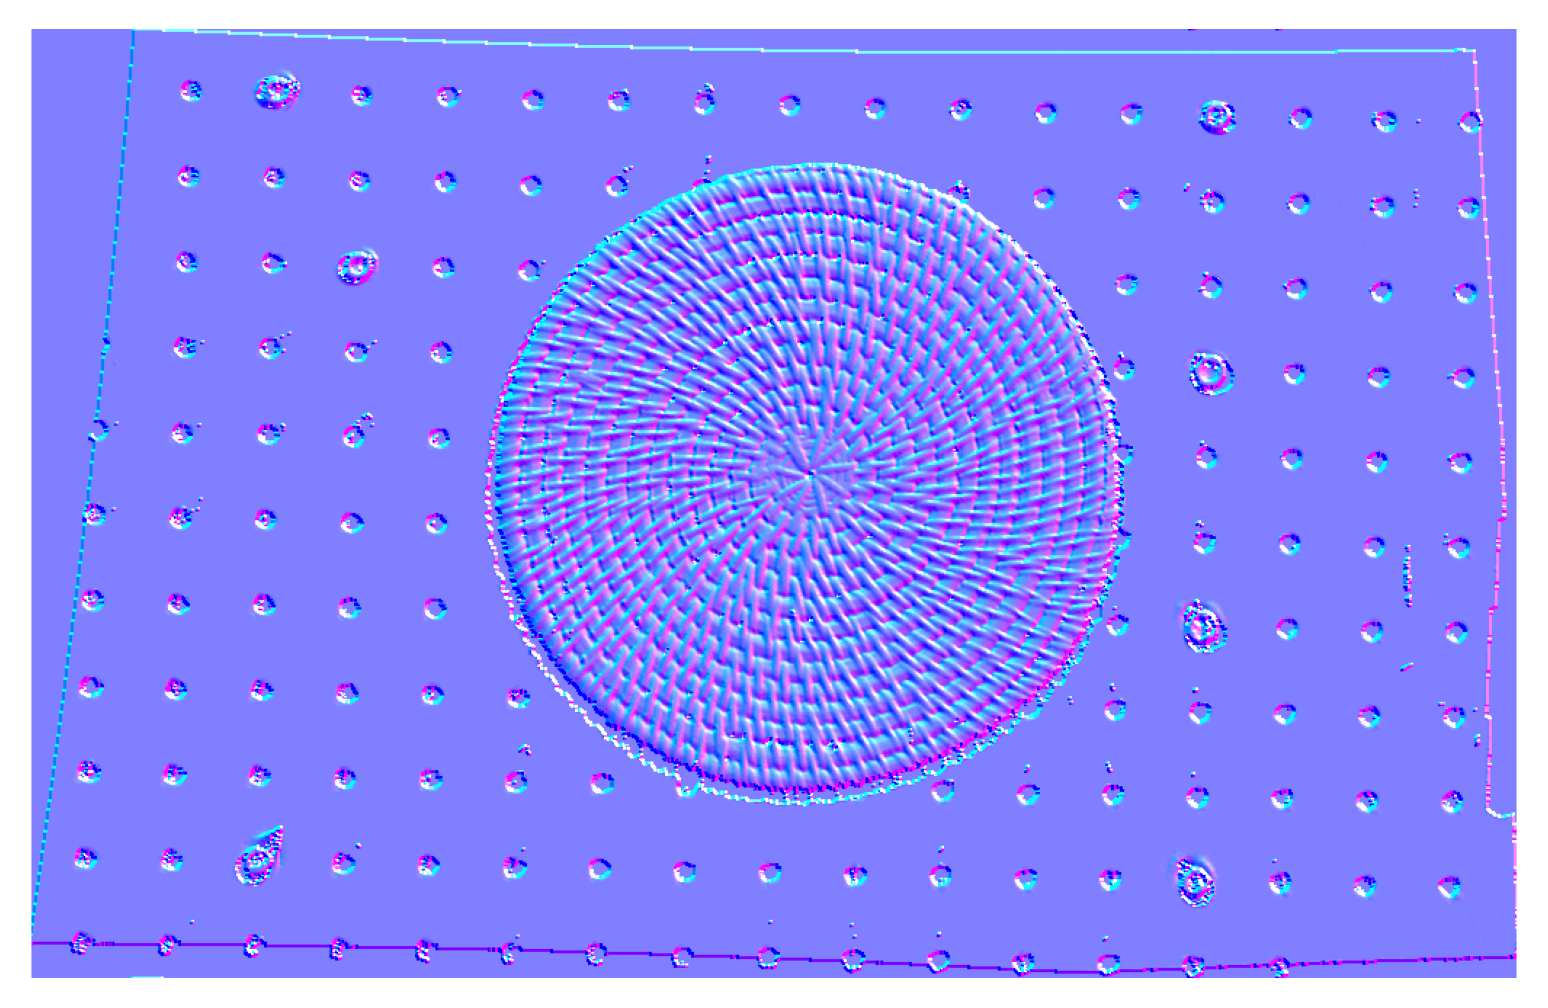

In [198]:
#image_size=height_map.shape
partial_func = partial(get_batch_normal_dev, image_size=image_size, heightMap=height_map,distance_per_pixel=distance_per_pixel,strength=0.8)
with Pool(coreNum) as p:
      result = list(tqdm(p.imap(partial_func, nums_list), total=len(nums_list)))

normalMap_circle = np.ones((image_size[0],image_size[1],3),dtype=np.float32)
normalMap_circle[0,:,:3] = np.array([0.5,0.5,1])
normalMap_circle[-1,:,:3] = np.array([0.5,0.5,1])
normalMap_circle[:,0,:3] = np.array([0.5,0.5,1])
normalMap_circle[:,-1,:3] = np.array([0.5,0.5,1])

for batchID in range(coreNum):
    batch_size = int(np.ceil(len(range(1,image_size[0]-1))/ coreNum))
    startID = min(batchID * batch_size,image_size[0])
    endID = min(startID+batch_size,image_size[0])
    if startID == image_size[0]:
       break
    #print(startID,endID)
    normalMap_circle[startID:endID,:,:3] = result[batchID]

plt.figure(dpi=300)
plt.axis('off')
plt.imshow(normalMap_circle)

In [199]:
plt.imsave(f'data/{forlder_name}/{forlder_name}_'+str(image_size[0])+'_'+str(image_size[1])+'_dev_normal.png',normalMap_circle)

In [200]:
coreNum = os.cpu_count()
idel_observe_length = 100
rayNum = 35

In [201]:
@nb.jit()
def getAO(observe_area,strength):
    M = np.clip(observe_area,0,1)
    areaHeight = observe_area.shape[0]
    areaWidht= observe_area.shape[1]
    c  = observe_length = min(areaHeight,areaWidht) // 2 
    if observe_length == 0 :
        return 1 - observe_area[0]
    observe_length =  min(observe_length,idel_observe_length)


    totalVisibilityValue = 0
    passed_positions = np.zeros((areaHeight,areaWidht),dtype = np.float32)
    

    for i in np.linspace(0,2*math.pi,rayNum):
        visibility = True
        obstacleHight = 0

        for j in range(observe_length+1):
            x = min(int(np.round(math.cos(i)*j)),observe_length-1)
            y = min(int(np.round(math.sin(i)*j)),observe_length-1)

            
            if visibility == False:
                if M[c+x,c+y] > obstacleHight:
                    obstacleHight = M[c+x,c+y]
                else:
                    M[c+x,c+y] = obstacleHight

            if (M[c+x,c+y]>0):
                if M[c+x,c+y] > obstacleHight:
                    obstacleHight = M[c+x,c+y]
                    visibility = False

            if passed_positions[c+x,c+y] == 0:
                totalVisibilityValue += min((1 - M[c+x,c+y]* strength) , 1) #用strength是因为波纹板没放平，高度图里面相对高度差太小了，做出了的AO高度波动太小
                #M[c+x,c+y]* strength)太大的话会产生负值，还需后续优化
            passed_positions[c+x,c+y] = 1
        
    return totalVisibilityValue/np.sum(passed_positions)

In [202]:
@nb.jit()
def get_observe_area(i,j,height_map,image_size):
    imageHeight = image_size[0]
    imageWidth = image_size[1]
    if (i < idel_observe_length ) or (j < idel_observe_length) or (imageHeight - i - 1 < idel_observe_length ) or (imageWidth -j - 1 < idel_observe_length):
        min_disctance = min(i,j,imageHeight - i - 1,imageWidth -j - 1)
        observe_area = height_map[i-min_disctance:i+1+min_disctance,j-min_disctance:j+1+min_disctance]
    else:
        observe_area = height_map[i+1-idel_observe_length:i+1+idel_observe_length,j+1-idel_observe_length:j+1+idel_observe_length]
    return np.clip(observe_area - height_map[i,j],0,1)

In [203]:
@nb.jit()
def get_batch_AO(batchID,image_size, height_Map, strength):
   
    imageHeight = image_size[0]
    imageWidth = image_size[1]
    batch_size = int(np.ceil(imageHeight/coreNum))
    startID = min(batchID * batch_size,imageHeight)
    endID = min(startID+batch_size,imageHeight)
    if startID == imageHeight:
        return []
    AO_Map = np.ones((endID-startID,imageWidth),dtype=np.float32)

    
    for i in range(startID,endID):
        for j in range(imageWidth):
            if min(i,j) == 1:
                AO_Map[i-startID,j] = 1 - height_Map[i,j]
            else:
                observe_area = get_observe_area(i,j,height_Map,image_size)
                AO_Map[i-startID,j] = getAO(observe_area,strength)
    return AO_Map

In [204]:
partial_func = partial(get_batch_AO, image_size=image_size, height_Map=height_map,strength=1)
nums_list = range(coreNum)
with Pool(coreNum) as p:
      result = list(tqdm(p.imap(partial_func, nums_list), total=len(nums_list)))

  0%|          | 0/48 [00:00<?, ?it/s]INFO - 2022-12-01 18:45:15,086 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,088 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,087 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,087 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,096 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,125 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,144 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,144 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,147 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,177 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,178 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,226 - transforms - finding looplift candidates
INFO - 2022-12-01 18:45:15,226 - transforms - finding looplift candidates


In [205]:
AOMap = np.ones(image_size)
#image_size = height_map.shape
imageHeight = image_size[0]
imageWidth = image_size[1]
for batchID in range(coreNum):
    batch_size = int(np.ceil(imageHeight/coreNum))
    startID = min(batchID * batch_size,imageHeight)
    endID = min(startID+batch_size,imageHeight)
    if startID == imageHeight:
       break
    #print(startID,endID)
    AOMap[startID:endID] = result[batchID]
AOMap = np.clip(0,1,AOMap)

In [206]:
imageHeight = image_size[0]
imageWidth = image_size[1]
for batchID in range(coreNum):
    batch_size = int(np.ceil(imageHeight/coreNum))
    startID = min(batchID * batch_size,imageHeight)
    endID = min(startID+batch_size,imageHeight)
    if startID == imageHeight:
       break
    #print(startID,endID)
    AOMap[startID:endID] = result[batchID]

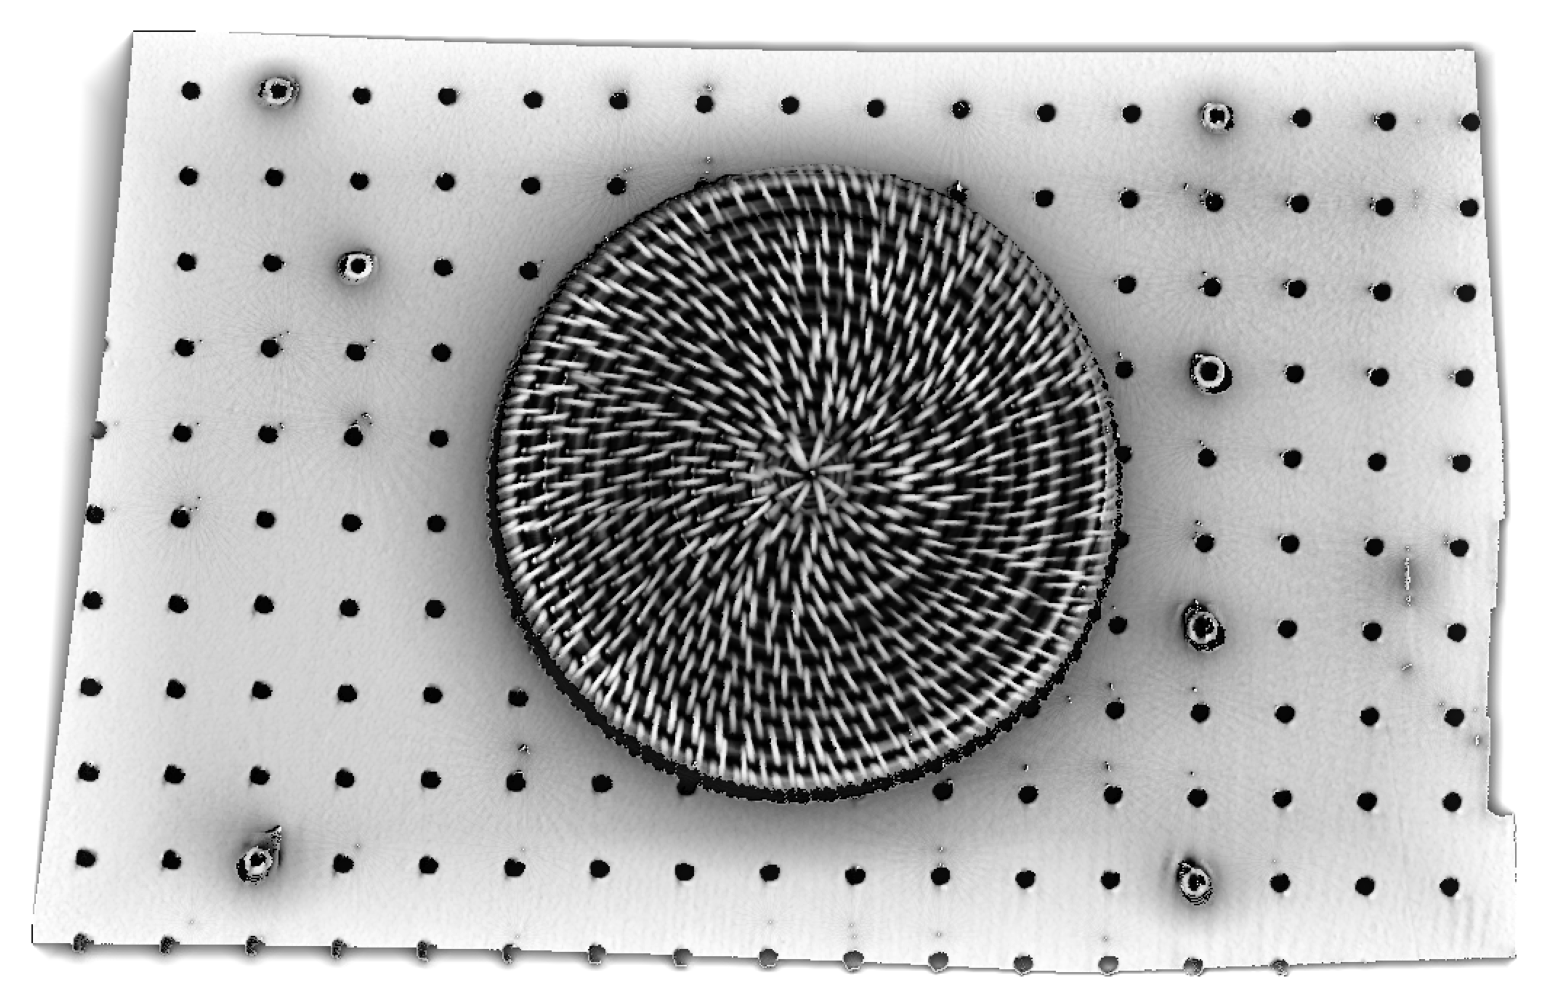

In [207]:
AOMap = np.clip(AOMap,0,1)
plt.figure(dpi=300)
plt.axis('off')
#plt.imshow(np.swapaxes(AOMap,0,1), cmap='gray')
plt.imshow(AOMap, cmap='gray')

In [ ]:
plt.imsave(f'data/{forlder_name}/{forlder_name}_'+str(image_size[0])+'_'+str(image_size[1])+'_AO.png',AOMap,cmap='gray')